In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

import random

In [2]:
import sys
sys.path.insert(0,'vp_class/')

In [3]:
from class_ou import OU, ou_gradient
from class_tou import tOU, tou_gradient

This code applies variational inference based on $\textbf{time-dependent}$ OU processes to the observations drawn from time-homogeneous OU process, as defined below. Note that we have chosen observational noise, i.e. variance of Gaussian noise and SDE variance to be 0.01 and 1.0 repectively.

In [4]:
alpha = torch.tensor([0.]).repeat(1, 1)
beta = torch.tensor([1.]).repeat(1, 1)
z0 = torch.tensor([10.]).repeat(1,1)
sde_sigma = 1.

In [5]:
true_sde = OU(t0 = 0, t1 = 8., z0 = z0, alpha = alpha, beta = beta, sigma = torch.tensor(sde_sigma).repeat(1,1), dN=801, timegrid='True')

1. Simulate prior process, i.e. time-homogeneous OU process whose SDE is given by

$$dX_t = -X_tdt + dW_t$$

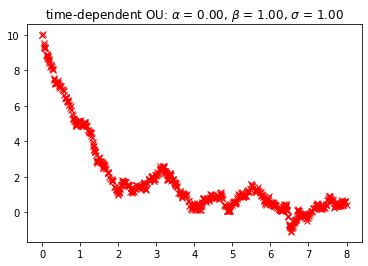

In [6]:
plt.plot(true_sde.pts.T, true_sde.trj.T, 'rx')
plt.title(r"time-dependent OU: $\alpha$ = %.2f" % true_sde.alpha + r", $\beta$ = %.2f" % true_sde.beta + r", $\sigma$ = %.2f" % true_sde.sigma)
plt.show()

In [7]:
obs_sigma = 0.1
obs = torch.from_numpy(np.random.normal(loc = true_sde.trj[0][::100], scale = obs_sigma)).reshape(-1, 1)
obs_time = true_sde.pts[0][::100]

2. Draw observations from Gaussian likelihood model with variance 0.01

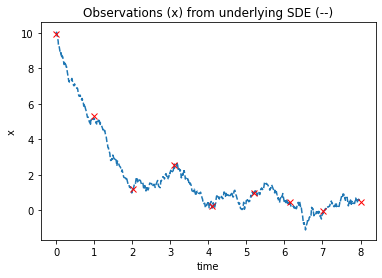

In [8]:
plt.title("Observations (x) from underlying SDE (--)")
plt.plot(true_sde.pts.T, true_sde.trj.T, '--')
plt.plot(true_sde.pts[0][::100], obs, 'rx')
plt.xlabel("time")
plt.ylabel("x")
plt.show()

3. Implement Variational inference based on $\textbf{time-inhomogeneous}$ OU process with SDE:

$$dZ_t = [-r(Z_t - m(t)) + m'(t)]dt + dW_t$$

The KL divergence between the prior and variational process is given by 

$$\log\exp{\frac{dP^{X}}{dP^{Z}}(Z) = \int_{t_{0}}}^{t_{1}}-Z_{t} + r(Z_{t}-m(t))-m'(t)dZ_{t} - 
\frac{1}{2}\int_{t_{0}}^{t_{1}}Z^{2}_{t} - (-r(Z_{t}-m(t) + m'(t))^{2}dt$$

where the relevant functions

$$m(t) = \alpha (B(t, \beta) - 1) + m_{0}$$

$$m'(t) = \alpha \beta B(t, \beta - 1)$$

$$B(s, \beta) = (s + 1)^{\beta}$$

Please note that $E(Z_t) = m(t)$. Here we consider a variational process with a linear mean function, i.e. $\beta = 1$, which results in $m(t) = \alpha t + m_{0}$. Our variational parameters, thus, include $r, \alpha, m_{0}$

In [9]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.sigma = ou.sigma
        self.r = ou.r
        self.m0 = ou.m0
        
    def KL_Riemann(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
        def B(s, beta):
            return (s+1) ** beta
        
        
        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
#         func = lambda s, z: -0.5 * (1-(r**2)) * z * z + alpha * beta * ( r * B(s, beta-1) + 1) * z \
#                     -0.5 * ((r**2) - 1) * (alpha**2) * (beta**2) * B(s, 2*(beta-1)) \
#                     -0.5 * (alpha * (B(s, beta) - 1) + m0 + r * alpha * beta * B(s, beta-1)) \
#                     * (2 * z - alpha * (B(s, beta) - 1) - m0 - r * alpha * beta * B(s, beta - 1))

        def m(s):
            return alpha * (B(s, beta) - 1) + m0
            
        def m_(s):
            return alpha * beta * B(s, beta-1)
        
        func = lambda s, z: ( (1-r) * z + r * m(s) + m_(s) ) * ( (1+r) * z - r * m(s) - m_(s)) \
                      
        
        # re-arrange t so that it starts from 0
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1) 
        num = func(t, self.ou.trj)
        return -0.5 * torch.trapezoid(num, x=t).reshape(-1, 1)
    
    def KL_Ito(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        D = alpha.shape[0]
        
        z0 = self.ou.z0

        z1 = self.ou.trj[:, -1].reshape(D, 1)
        
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1) 
        
        t0 = t[:, 0]
        t1 = t[:, -1]

        # Obtain the rest 
        def A(s, u):
            return (r - 1) * 0.5 * (u ** 2) - u * r * alpha * (((s+1) ** beta) - 1) - r * m0 * u - alpha * beta * (s+1) * u
        
        def B(s, beta):
            return (s+1) ** beta
        
        integral = lambda s, z: r * alpha * beta * B(s, beta-1) * z + alpha * beta * z
        
        return A(t1, z1) - A(t0, z0) - 0.5 * (r - 1) * (t1 - t0) + torch.trapezoid(integral(t, self.ou.trj), x=t).reshape(-1, 1)
    
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


**Variational inference based on time-inhomogeneous OU process. We use $T-1$ different variational process to approximate the posterior process on each interval $[t_{i}, t_{i+1}]$ such that $i=0, \cdots, T-1$**

Heere, we implement our black box variatioanl inference for SDE. A gradient descent algorithm is used to optimize the Evidence Lower Bound (ELBO), i.e. the sum of negative $KL(P^{Z}|P^{X})$ and the likelihood $P(Y|Z)$. The gradient of the ELBO is estimated through score function estimator. 

In [10]:
import tqdm as tq

In [95]:
D = 50
S = 100
learning_rate = 0.003
lr = learning_rate
IT = 1000
dN = 200
z0 = obs[0]

# Linear mean function
beta_ = torch.tensor([1.])
beta_D = beta_.repeat(D, 1)
beta_S = beta_.repeat(S, 1)

vp_mean = []
vp_std = []
vp_pts = []

elbo_traces = np.empty((len(obs_time) - 1, IT-1))
KL_traces = np.empty((len(obs_time) -1 , IT-1))
LL_traces = np.empty((len(obs_time) -1 , IT-1))
pars_traces = np.empty((3, len(obs_time) - 1, IT))

sde_sigma_D = torch.tensor([sde_sigma]).repeat(D, 1)
sde_sigma_S = torch.tensor([sde_sigma]).repeat(S, 1)
for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    alpha_ = torch.tensor([0.])
    r_ = torch.rand(1) + 7.
    if t > 1:
        r_ = torch.tensor([7.])
    m0_ = obs[t].clone().detach()
    
    i = 0
    for i in range(IT): 
        alpha_D = alpha_.repeat(D, 1)
        r_D = r_.repeat(D, 1)
        z0_D = z0.repeat(D, 1)
        m0_D = m0_.repeat(D, 1)
        # Compute (negative) ELBO
        if i > 0:
            vi_ = tOU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma_D, r=r_D, dN=dN, timegrid = 'False')
            elbo_ = ELBO(vi_)
            kl_ = elbo_.KL_Riemann() + elbo_.KL_Ito()
            LL_ = elbo_.log_prob(obs[t+1].repeat(D, 1), obs_sigma)
            elbo_estimate = -1 * (kl_ + LL_)
            elbo_traces[t, i-1] = torch.mean(elbo_estimate).clone()
            KL_traces[t, i-1] = torch.mean(kl_).clone()
            LL_traces[t, i-1] = torch.mean(LL_).clone()
            if i % 50 == 1:
                print("(Neg) elbo = ", torch.nanmean(elbo_estimate).data.numpy())
        # Obtain score function estimator of the gradient
        vi = tOU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma_D, r=r_D, dN=dN, timegrid = 'False')
        elbo = ELBO(vi)

        gradient = tou_gradient(vi.pts, vi.trj, torch.stack([alpha_D, beta_D, m0_D, r_D, sde_sigma_D]).view(-1, D, 1))
#         print("scores = ", scores)
        f_of_X = -1 * (elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma) + elbo.KL_Riemann() + elbo.KL_Ito())
#         print("Ito = ", elbo.KL_ito(), "Rest = ", elbo.KL_rest(), "LL = ", elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma))
#         print("f_of_X = ", torch.nanmean(f_of_X))
#         print("NLL = ", "KL_Ito = ", "KL_rest = ")
        
#         print("scores_beta = ", torch.nanmean(scores['beta']), "scores_alpha = ", torch.nanmean(scores['alpha']))
        m0_grad = torch.nanmean(f_of_X * gradient['m0'])
        alpha_grad = torch.nanmean(f_of_X * gradient['alpha'])
        r_grad = torch.nanmean(f_of_X * gradient['r'])
#         print("beta_grad = ", beta_grad, "alpha_grad = ", alpha_grad, "r_grad = ", r_grad)

        # Update the parameter

        m0_ -= learning_rate * m0_grad
        alpha_ -= learning_rate * alpha_grad
        if t == 1:
            r__ = r_ - learning_rate * 10 * r_grad
        elif t > 1:
            r__ = r_ - learning_rate * 40 * r_grad
        else:
            r__ = r_ - learning_rate * 3 * r_grad

#             It is to ensure r should be strictly positive (i.e. projected gradient method)
        while r__ < 0:
            r__ = r_ - lr * r_grad
            lr *= 0.5
        r_ = r__

        pars_traces[0, t, i] = alpha_.clone()
        pars_traces[1, t, i] = m0_.clone()
        pars_traces[2, t, i] = r_.clone()

        if i % 50 == 0:
            print("alpha = ", alpha_.data.numpy(), "m0 = ", m0_.data.numpy(), "r = ", r_.data.numpy())
        i += 1
#     Compute posteiror mean (based on posterior sample)
    posterior = tOU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0.repeat(S, 1), m0 = m0_[0].repeat(S, 1), alpha = alpha_.repeat(S,1), beta = beta_S, sigma = sde_sigma_S, r = r_.repeat(S,1), dN = dN, timegrid='True')

    
    if t > 0:
        post_mean_ = posterior.trj.mean(axis=0)[1:]
        post_std_ = posterior.trj.std(axis=0)[1:]
        post_pts_ = posterior.pts.mean(axis=0)[1:]
    else:
        post_mean_ = posterior.trj.mean(axis=0)
        post_std_ = posterior.trj.std(axis=0)
        post_pts_ = posterior.pts.mean(axis=0)
    
    vp_mean.append(post_mean_.clone().data.numpy())
    vp_std.append(post_std_.clone().data.numpy())
    vp_pts.append(post_pts_.clone().data.numpy())
#     z0 = torch.tensor(obs[t+1])
    z0 = post_mean_.clone()[-1]
#     print("posterior_mean = ", z0)
# score.compute_score()

  0%|                                                     | 0/8 [00:00<?, ?it/s]

alpha =  [-6.029428] m0 =  [4.91205894] r =  [7.7730675]
(Neg) elbo =  2118.804753360717
alpha =  [-3.4666224] m0 =  [8.84610635] r =  [7.249446]
(Neg) elbo =  15.087194615756438
alpha =  [-3.4423301] m0 =  [8.63132476] r =  [7.311892]
(Neg) elbo =  15.26292844387456
alpha =  [-3.32872] m0 =  [8.54055193] r =  [7.2533464]
(Neg) elbo =  13.700666100876616
alpha =  [-3.2556162] m0 =  [8.64964942] r =  [7.289755]
(Neg) elbo =  14.989524029722368
alpha =  [-3.278825] m0 =  [8.68421677] r =  [7.317056]
(Neg) elbo =  14.64368602179023
alpha =  [-3.2322888] m0 =  [8.57328374] r =  [7.328925]
(Neg) elbo =  13.706686675684931
alpha =  [-3.1975517] m0 =  [8.41214624] r =  [7.4405704]
(Neg) elbo =  14.066724251235014
alpha =  [-3.218237] m0 =  [8.45721584] r =  [7.3578]
(Neg) elbo =  12.544363940472412
alpha =  [-3.2394133] m0 =  [8.44239141] r =  [7.3117685]
(Neg) elbo =  13.657409545771353
alpha =  [-3.4972184] m0 =  [8.69665237] r =  [7.2329097]
(Neg) elbo =  13.354702383453594
alpha =  [-3.44

 12%|█████▋                                       | 1/8 [00:45<05:20, 45.85s/it]

alpha =  [-0.83511573] m0 =  [5.59350694] r =  [7.351449]
(Neg) elbo =  680.1404363816823
alpha =  [-4.6099358] m0 =  [5.81361166] r =  [6.0293317]
(Neg) elbo =  15.367267884940176
alpha =  [-4.38916] m0 =  [5.57162818] r =  [6.5900054]
(Neg) elbo =  15.53813290579119
alpha =  [-4.124074] m0 =  [5.40930538] r =  [7.154473]
(Neg) elbo =  13.534652292384548
alpha =  [-4.0818343] m0 =  [5.33469213] r =  [7.4645705]
(Neg) elbo =  13.315433517608962
alpha =  [-3.9622862] m0 =  [5.11664178] r =  [7.751296]
(Neg) elbo =  12.155874789592067
alpha =  [-3.7679892] m0 =  [5.01138847] r =  [8.097709]
(Neg) elbo =  11.368985038990518
alpha =  [-3.6400928] m0 =  [4.85450689] r =  [8.226016]
(Neg) elbo =  11.015816179216712
alpha =  [-3.5397894] m0 =  [4.7884844] r =  [8.185353]
(Neg) elbo =  11.053689840962692
alpha =  [-3.674676] m0 =  [4.90871057] r =  [8.194719]
(Neg) elbo =  11.44793021329572
alpha =  [-3.5961556] m0 =  [4.92310452] r =  [8.410596]
(Neg) elbo =  11.485127903013048
alpha =  [-3.6

 25%|███████████▎                                 | 2/8 [01:31<04:33, 45.53s/it]

alpha =  [-0.14684036] m0 =  [0.80411678] r =  [7.52425]
(Neg) elbo =  172.8635181338766
alpha =  [0.87372154] m0 =  [1.48680412] r =  [8.951054]
(Neg) elbo =  9.109432909328275
alpha =  [0.85345405] m0 =  [1.53592796] r =  [9.248499]
(Neg) elbo =  9.61917687008201
alpha =  [0.9743016] m0 =  [1.43784419] r =  [9.266648]
(Neg) elbo =  9.575304688522174
alpha =  [0.98322076] m0 =  [1.41929769] r =  [9.857968]
(Neg) elbo =  8.684034870289272
alpha =  [1.042898] m0 =  [1.2410093] r =  [9.972199]
(Neg) elbo =  9.635535717215598
alpha =  [1.1901935] m0 =  [1.23753883] r =  [9.559678]
(Neg) elbo =  10.20632110956616
alpha =  [1.272935] m0 =  [1.18435611] r =  [9.577343]
(Neg) elbo =  9.743081956083955
alpha =  [1.1415743] m0 =  [1.07896736] r =  [9.625374]
(Neg) elbo =  10.165584601916791
alpha =  [1.1118139] m0 =  [1.16462519] r =  [9.115698]
(Neg) elbo =  9.883783802751854
alpha =  [1.1715648] m0 =  [1.25918639] r =  [9.241927]
(Neg) elbo =  9.49045731682114
alpha =  [1.0492278] m0 =  [1.22

 38%|████████████████▉                            | 3/8 [02:17<03:50, 46.01s/it]

alpha =  [-1.0758002] m0 =  [1.41967045] r =  [7.367759]
(Neg) elbo =  5.620251479469131
alpha =  [-1.2666134] m0 =  [1.50178877] r =  [7.363332]
(Neg) elbo =  5.025187472288945
alpha =  [-1.3379842] m0 =  [1.56839659] r =  [7.7641025]
(Neg) elbo =  5.4933089842114
alpha =  [-1.4178224] m0 =  [1.69406023] r =  [7.793692]
(Neg) elbo =  5.814784941336967
alpha =  [-1.4654881] m0 =  [1.72308691] r =  [8.194756]
(Neg) elbo =  5.470228859200605
alpha =  [-1.6228033] m0 =  [1.80030722] r =  [8.256028]
(Neg) elbo =  5.426544689764889
alpha =  [-1.6895008] m0 =  [1.83306419] r =  [8.620798]
(Neg) elbo =  4.908360017721483
alpha =  [-1.7245855] m0 =  [1.95032154] r =  [8.656441]
(Neg) elbo =  5.0760586402527474
alpha =  [-1.8181155] m0 =  [1.91926189] r =  [8.975438]
(Neg) elbo =  6.486306719131987
alpha =  [-1.7465864] m0 =  [2.0823459] r =  [8.8822]
(Neg) elbo =  4.907475207587975
alpha =  [-1.7410953] m0 =  [2.00361874] r =  [9.200045]
(Neg) elbo =  5.240495075987357
alpha =  [-1.7736933] m0

 50%|██████████████████████▌                      | 4/8 [03:04<03:04, 46.22s/it]

alpha =  [0.27701548] m0 =  [0.52823459] r =  [7.27138]
(Neg) elbo =  5.197388095745673
alpha =  [0.38106623] m0 =  [0.47887942] r =  [7.7462015]
(Neg) elbo =  4.550498118383991
alpha =  [0.48712352] m0 =  [0.43555446] r =  [8.197742]
(Neg) elbo =  5.179127335096588
alpha =  [0.5053681] m0 =  [0.30288554] r =  [8.608462]
(Neg) elbo =  3.825948741762197
alpha =  [0.5660213] m0 =  [0.26387712] r =  [8.936289]
(Neg) elbo =  3.9924565135353407
alpha =  [0.59905124] m0 =  [0.28090889] r =  [9.172697]
(Neg) elbo =  4.5042873592248025
alpha =  [0.54564303] m0 =  [0.24889247] r =  [9.39084]
(Neg) elbo =  4.967893786164625
alpha =  [0.56980807] m0 =  [0.30103931] r =  [9.390587]
(Neg) elbo =  5.211192193352264
alpha =  [0.6592331] m0 =  [0.21465694] r =  [9.494118]
(Neg) elbo =  5.704798713231221
alpha =  [0.6637464] m0 =  [0.11042989] r =  [9.669798]
(Neg) elbo =  5.466111995023668
alpha =  [0.6611226] m0 =  [0.18758598] r =  [9.607733]
(Neg) elbo =  3.81258023663738
alpha =  [0.68365055] m0 =

 62%|████████████████████████████▏                | 5/8 [03:50<02:18, 46.21s/it]

alpha =  [-0.1225397] m0 =  [0.8147416] r =  [6.9528856]
(Neg) elbo =  6.013719396441894
alpha =  [-0.2894824] m0 =  [0.68641981] r =  [8.261611]
(Neg) elbo =  3.4350652585065946
alpha =  [-0.33381727] m0 =  [0.73360204] r =  [8.702421]
(Neg) elbo =  3.8721305248057325
alpha =  [-0.3510295] m0 =  [0.74863579] r =  [9.140651]
(Neg) elbo =  3.642810683083363
alpha =  [-0.32883865] m0 =  [0.83091816] r =  [9.531359]
(Neg) elbo =  3.2368929675548563
alpha =  [-0.38662964] m0 =  [0.84096211] r =  [9.733479]
(Neg) elbo =  2.907833950637588
alpha =  [-0.35562032] m0 =  [0.80825365] r =  [9.896908]
(Neg) elbo =  2.5545504638265
alpha =  [-0.3559771] m0 =  [0.81049682] r =  [9.807318]
(Neg) elbo =  3.081357968348809
alpha =  [-0.35621953] m0 =  [0.81561891] r =  [9.905446]
(Neg) elbo =  4.128681256343625
alpha =  [-0.3950222] m0 =  [0.78466486] r =  [10.057335]
(Neg) elbo =  2.474359031474857
alpha =  [-0.36678833] m0 =  [0.87458161] r =  [10.277684]
(Neg) elbo =  2.7949232273848277
alpha =  [-

 75%|█████████████████████████████████▊           | 6/8 [04:36<01:32, 46.07s/it]

alpha =  [-0.14455186] m0 =  [0.2892497] r =  [6.8825912]
(Neg) elbo =  3.125945472854148
alpha =  [-0.2942059] m0 =  [0.20469531] r =  [8.280314]
(Neg) elbo =  2.998038807914744
alpha =  [-0.30272174] m0 =  [0.25509448] r =  [9.060564]
(Neg) elbo =  2.5556805100377886
alpha =  [-0.33990476] m0 =  [0.22167774] r =  [9.255575]
(Neg) elbo =  3.1539902187411566
alpha =  [-0.35657558] m0 =  [0.28428237] r =  [9.339482]
(Neg) elbo =  2.7061962035463214
alpha =  [-0.42189968] m0 =  [0.34089403] r =  [9.7303505]
(Neg) elbo =  2.9260954347455166
alpha =  [-0.45696014] m0 =  [0.29877732] r =  [9.834623]
(Neg) elbo =  3.868379748271513
alpha =  [-0.46025518] m0 =  [0.43282308] r =  [9.982223]
(Neg) elbo =  3.263874250873326
alpha =  [-0.45726806] m0 =  [0.4055528] r =  [10.105459]
(Neg) elbo =  2.72498779096188
alpha =  [-0.4531165] m0 =  [0.42191216] r =  [10.334484]
(Neg) elbo =  3.208986495250132
alpha =  [-0.46703136] m0 =  [0.41803108] r =  [10.61615]
(Neg) elbo =  3.0318361766712445
alpha 

 88%|███████████████████████████████████████▍     | 7/8 [05:22<00:46, 46.16s/it]

alpha =  [0.03951222] m0 =  [-0.10909135] r =  [7.1353145]
(Neg) elbo =  16.368277298625074
alpha =  [0.34274712] m0 =  [0.17988675] r =  [8.345685]
(Neg) elbo =  3.0214428310670822
alpha =  [0.3317917] m0 =  [0.08574765] r =  [8.668955]
(Neg) elbo =  3.9845781069727555
alpha =  [0.38447437] m0 =  [0.11361015] r =  [8.982311]
(Neg) elbo =  3.6456804226956425
alpha =  [0.39961064] m0 =  [0.03529549] r =  [9.581231]
(Neg) elbo =  4.01530604954977
alpha =  [0.43067974] m0 =  [0.04576466] r =  [9.731475]
(Neg) elbo =  3.336110957276007
alpha =  [0.42012846] m0 =  [0.04264688] r =  [10.118689]
(Neg) elbo =  3.2124550534351157
alpha =  [0.39609084] m0 =  [-0.0039666] r =  [9.928595]
(Neg) elbo =  4.229779945526222
alpha =  [0.40588552] m0 =  [0.09549187] r =  [9.95134]
(Neg) elbo =  3.205279884021556
alpha =  [0.39543363] m0 =  [0.04084969] r =  [9.997617]
(Neg) elbo =  2.9194971920319266
alpha =  [0.39588657] m0 =  [0.05358607] r =  [9.947428]
(Neg) elbo =  3.3605593035151062
alpha =  [0.37

100%|█████████████████████████████████████████████| 8/8 [06:08<00:00, 46.08s/it]


4. Visualize the outcome

Trace plot: ELBO

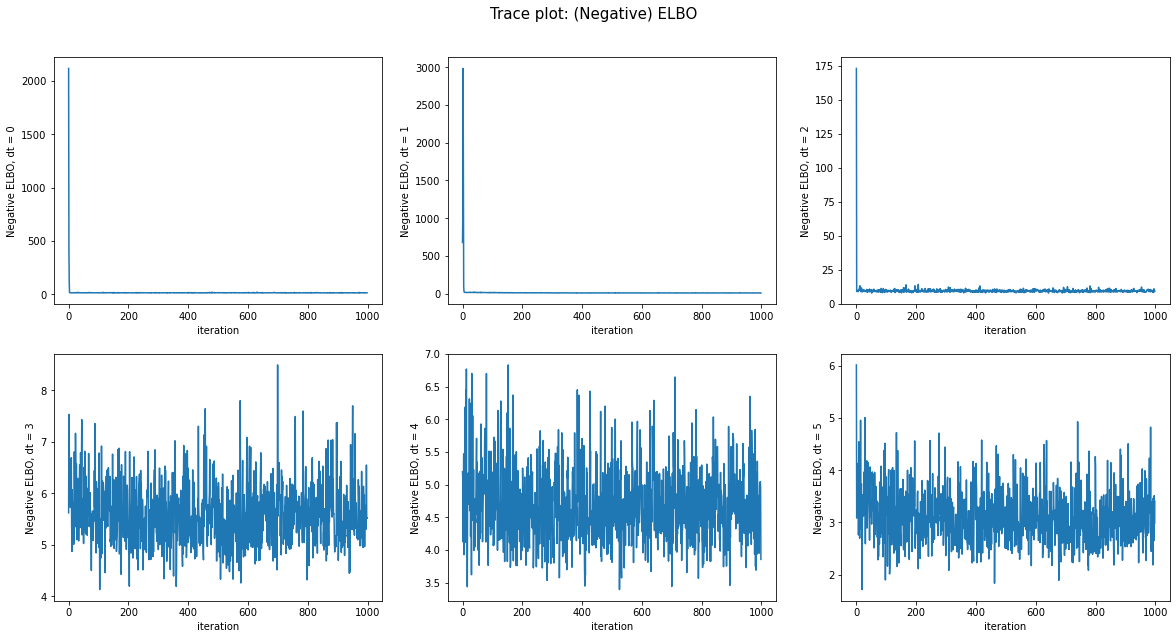

In [96]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(elbo_traces[t, :])), elbo_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

Trace plot: KL divergence

Most of the KL divergence estimate is greater than 0. The KL divergence estimate at the last time interval is close to 0, which suggests that the variational process is very similar to prior process on this interval.

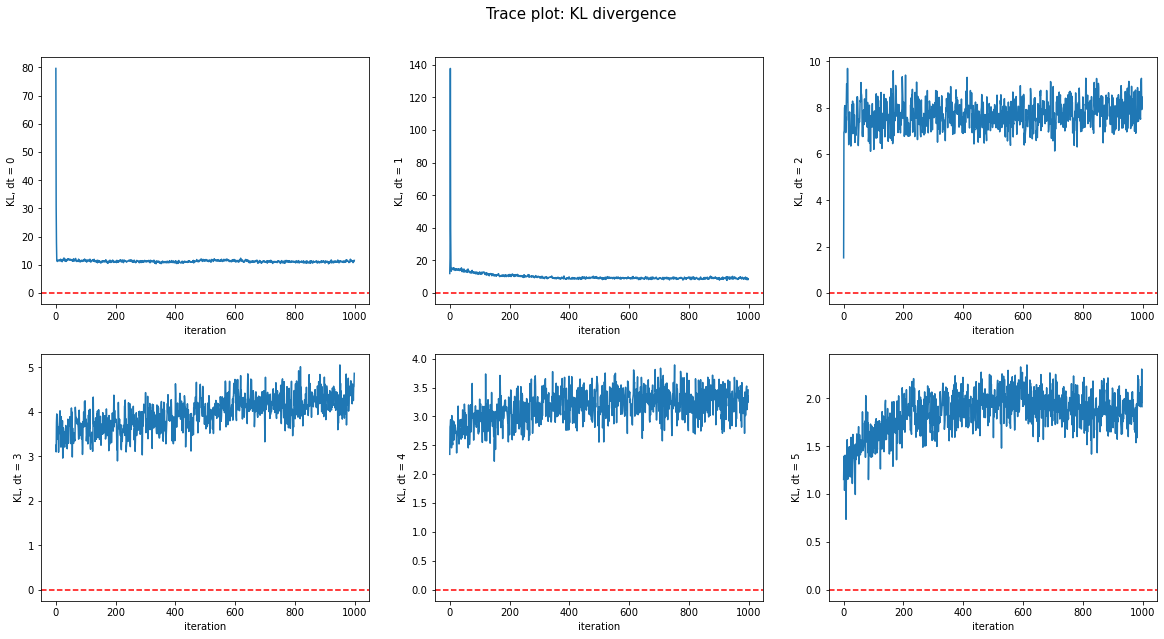

In [97]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(KL_traces[t, :])), -1 * KL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("KL, dt = %d" % t)
    ax.axhline(0, color='red', linestyle='dashed')
    t += 1
    
plt.suptitle("Trace plot: KL divergence", size=15, y=0.95)
plt.show()

Trace plot: NLL

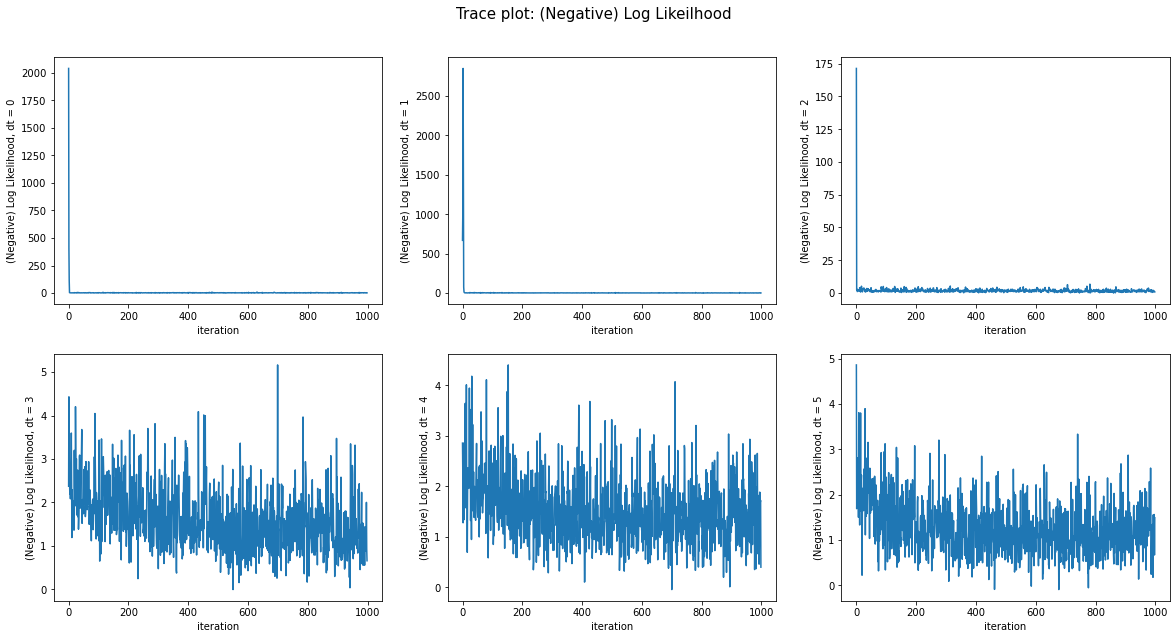

In [98]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(LL_traces[t, :])), -1 * LL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("(Negative) Log Likelihood, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) Log Likeilhood", size=15, y=0.95)
plt.show()

Trace plot: parameters

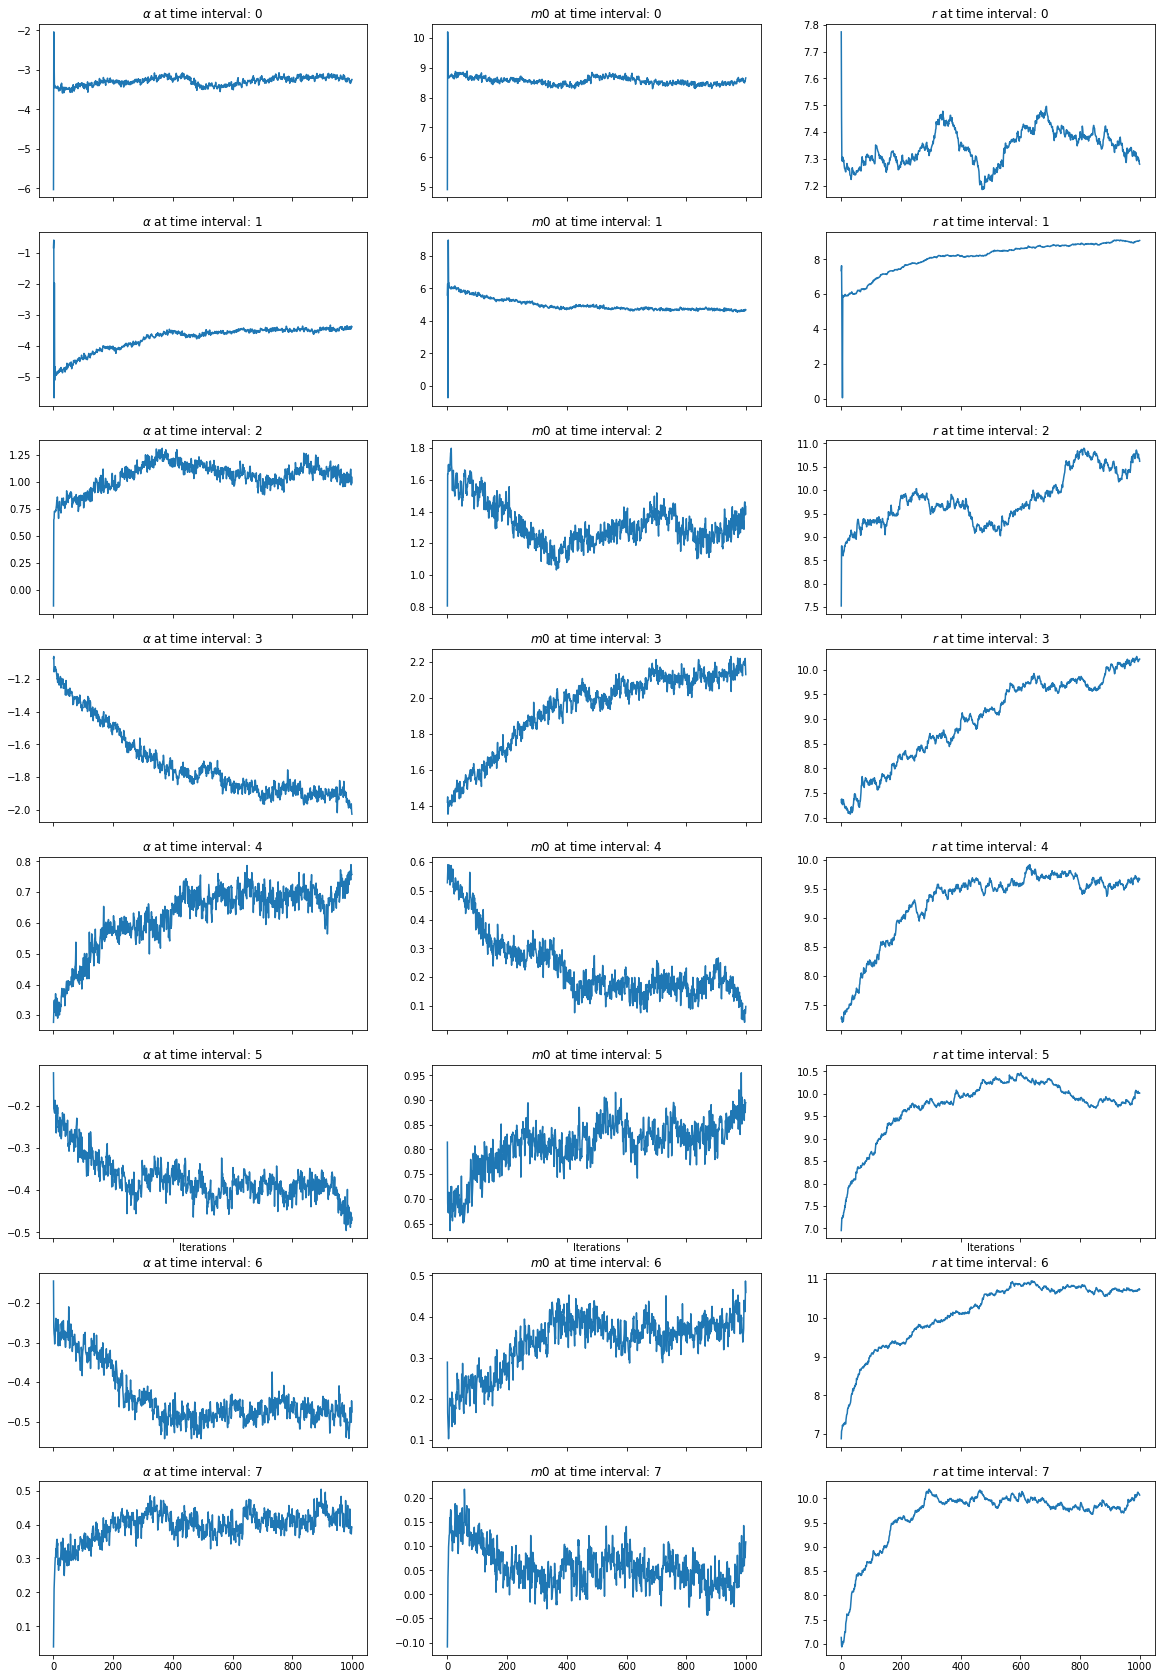

In [99]:
fig, ax = plt.subplots(nrows=pars_traces.shape[1], ncols=3, figsize=(20, 30), sharex='all')
names = [r'$\alpha$', r'$m0$', r'$r$']
for j, ax in enumerate(ax.ravel()):
    i = j % 3
    t = j // 3
    ax.plot(np.arange(pars_traces[i, t, :].shape[0]), pars_traces[i, t, :])
    ax.set_title(names[i] + " at time interval: %d" % t)
#     ax.set_yticks(np.linspace(0,2,10))
    if t == 5:
        ax.set_xlabel("Iterations")
plt.show()

**Posterior approximation**

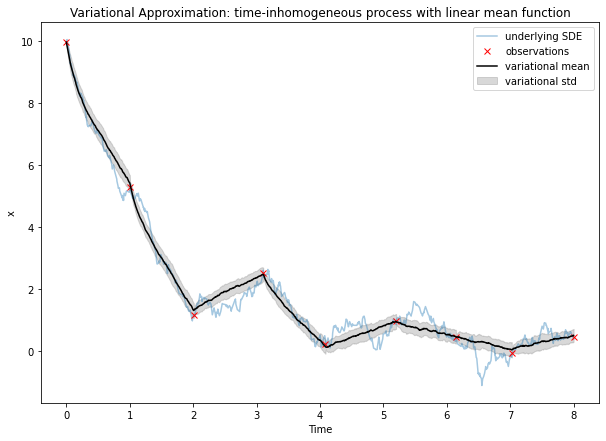

In [100]:
vi_mean = np.concatenate(vp_mean)
vi_var = np.concatenate(vp_std)
vi_pts = np.concatenate(vp_pts)

plt.figure(figsize=(10, 7))
plt.plot(true_sde.pts.T, true_sde.trj.T, label="underlying SDE", alpha=0.4)
plt.plot(obs_time, obs, 'rx', label='observations')
plt.plot(vi_pts, vi_mean, color='black', label='variational mean')
plt.fill_between(vi_pts, vi_mean + vi_var, vi_mean - vi_var, alpha=0.3, color='grey', label='variational std')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Variational Approximation: time-inhomogeneous process with linear mean function")
plt.show()

In [21]:
import pickle

In [22]:
with open('EX02_OU', 'wb') as f:
    pickle.dump(true_sde, f)
    pickle.dump(obs, f)
    pickle.dump(obs_time, f)
    pickle.dump(obs_sigma, f)
    pickle.dump(sde_sigma, f)